In [1]:
import numpy as np
import pandas as pd
# import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.backends.backend_pdf import PdfPages

from spectral_cube import SpectralCube
from scipy.stats import median_abs_deviation as mad
# from scipy.optimize import curve_fit

from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
import regions

import os
import sys
sys.executable

import glob
import cv2

from PIL import Image

import warnings
warnings.filterwarnings('ignore', message='The maxmimum and minimum spectral channel in the spectralslab are identical*')
warnings.filterwarnings('ignore', message='Cube is a Stokes cube*')
warnings.filterwarnings('ignore', message='WCS1 is missing card PV2_1*')
warnings.filterwarnings('ignore', message='This function (<function BaseSpectralCube.std at 0x7fe62a3cfc10>)*')
warnings.filterwarnings('ignore', message='invalid value encountered in cast*')
warnings.filterwarnings('ignore', message='Degrees of freedom <= 0 for slice.*')
warnings.filterwarnings('ignore', message='Mean of empty slice*')


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
## Function to get 2d noise mask

def make_spatial_noise_mask(file_name, vmin, vmax, dv_min, dv_max, rms_level = 3):
    '''
    Function to make a spatial mask to remove noisy pixels ideally using non pb corrected image.
    
    Arguments:
    file_name (str): Name of file to be used for mask. Preferably non primary beam corrected, as the noise is uniform.
    vmin (float) : Min. velocity of expected emission
    vmax (float) : Max. velocity of expected emission
    dv_min (float) : Min. velocity offset from channels with emission
    dv_max (float) : Max. velocity offset from channels with emission
    rms_level (float) : Sigma level to mask upto (3 by default)
    
    Output:
    mask_spatial (boolean array) :  3D mask, masking noisy pixels
    rms2use (float*flux_units) : rms flux computed
    '''

    ## Reading file 
    hdu_nocor = fits.open(file_name)[0]   # Reading file header
    cube_init_nocor = SpectralCube.read(hdu_nocor).with_spectral_unit(u.km/u.s, velocity_convention='radio',rest_value=hdu_nocor.header['RESTFRQ']*u.Hz)
    cube_init_nocor.allow_huge_operations=True # To avoid crashing

    ## Setting velocity units
    vmin *= u.km/u.s
    vmax *= u.km/u.s
    dv_min *= u.km/u.s
    dv_max *= u.km/u.s

    ## Computing rms
    cubev1 = cube_init_nocor.spectral_slab(vmin-dv_max,vmin-dv_min)  # np functions with big cubes give errors, https://spectral-cube.readthedocs.io/en/latest/big_data.html
    cubev2 = cube_init_nocor.spectral_slab(vmax+dv_min,vmax+dv_max)
    rms_val = ((np.std(cubev2[:,:,:])+np.std(cubev1[:,:,:]))/2)   # one no. 
    
    ## Creating mask based on rms_level
    rms2use = rms_val
    mask_spatial = cube_init_nocor > rms_level*rms2use

    return(mask_spatial,rms2use)

In [3]:
## Setting file names
fig_path = '/Users/agupta/Desktop/work/BHB2007/figures/'
fits_dir = '/Users/agupta/Desktop/work/BHB2007/fits_files/'   # directory of fits file
file_c18o = 'BHB1_C1_ACA_C18O_jupyter_mosaicgridder.pbcor.fits'
file_13co = 'BHB1_C1_ACA_13CO_jupyter_mosaicgridder.pbcor.fits'
file_12co = 'BHB1_C1_ACA_CO_jupyter_mosaicgridder.pbcor.fits'

file_names = {'12co':fits_dir+file_12co,'13co':fits_dir+file_13co,'c18o':fits_dir+file_c18o }
labels = ['CO (2-1)','13CO (2-1)','C18O (2-1)']
mol_line_labels = {list(file_names.keys())[i]: labels[i] for i in range(3)} # labels for each line

In [4]:
## Continuum image for contours
# cont_file_name = 'BHB1.spw25_27_29_31_33.continuum.selfcal.pbcor.fits'
cont_file_name = 'Target_BHB2007_1_Band_6_initial.image.tt0.fits'
cont_file = fits_dir+cont_file_name
hdu_cont = fits.open(cont_file)[0]   # Reading file header
cont_dat = hdu_cont.data[0,0]
print("Continuum image properties:")
print(f"Wavelength = {(const.c/(hdu_cont.header['CRVAL3']*u.Hz)).to(u.micron)}")
print(f"RMS:{(np.nanstd(cont_dat)*u.Jy).to(u.mJy)}, Beam: {hdu_cont.header['BMAJ']*60*60},{hdu_cont.header['BMIN']*60*60},{hdu_cont.header['BPA']}")

Continuum image properties:
Wavelength = 1336.1382900625601 micron
RMS:0.031870684324530885 mJy, Beam: 1.2989403009413998,1.00631630420676,71.23058319092


In [5]:
## Source parameters
obj_name = 'BHB1'
src_dist = 163*u.pc
src_v = 3.6*u.km/u.s # Systemic velocity, this one is just from visual inspection
src_M = 2.23 *u.solMass
src_ra = SkyCoord("17 11 03.9294631032", "-27 22 55.199684244", unit=(u.hourangle, u.deg)).ra.deg
src_dec = SkyCoord("17 11 03.9294631032", "-27 22 55.199684244", unit=(u.hourangle, u.deg)).dec.deg

## Code parameters
save_fig = False
data_crop = True
continuum = True

In [6]:
## Setting velocity range
vsep = 5*u.km/u.s
vmin = src_v-vsep # Min. velocity of interest
vmax = src_v+vsep # Max. velocity of interest 

## Cleaning cubes

scubes = {}
scubes_rms = {}

for mol_line in file_names.keys():
    fits_fil = file_names[mol_line] # path of the fits file to be read
    
    ## Reading main data cube
    hdu = fits.open(fits_fil)[0]   # Reading file header
    cube_init = SpectralCube.read(hdu).with_spectral_unit(u.km/u.s, velocity_convention='radio',rest_value=hdu.header['RESTFRQ']*u.Hz)
    
    if len(cube_init.spectral_axis) <2:
        print("Cube just has {} channels.. skipping it..".format(len(cube_init.spectral_axis)))
        break

    scube = cube_init # Cube as SpectralCube object
    
    ## Extracting useful info from header
    cenra = hdu.header['CRVAL1']
    cendec = hdu.header['CRVAL2']
    delta = hdu.header['CDELT2']
    xc_pix = hdu.header['CRPIX1']
    yc_pix = hdu.header['CRPIX2']
    ## Beam information
    try:
        bmaj = hdu.header['BMAJ']
        bmin = hdu.header['BMIN']
        bpa = hdu.header['BPA']
    except Exception as e:
        print("Beam info not available in header, taking medians...")
        hdu_beam = fits.open(fits_fil)[1]
        bmaj = np.nanmedian(hdu_beam.data['BMAJ'])
        bmin = np.nanmedian(hdu_beam.data['BMIN'])
        bpa = np.nanmedian(hdu_beam.data['BPA'])
        
    ## Filtering cube
    dv1 = 2*u.km/u.s
    dv2 = 6*u.km/u.s
    rms_level = 2
    fits_fil_nocor = fits_fil.replace('.pbcor', '')
    mask_spatial,rms2use = make_spatial_noise_mask(fits_fil_nocor, vmin.value, vmax.value, dv1.value, dv2.value, rms_level)
    cube_init_masked = cube_init.with_mask(mask_spatial)
    scubes_rms[mol_line] = rms2use
    ## Old method for 2D noise threshold
    # cubev1 = scube.spectral_slab(vmin-dv2,vmin-dv1)  # np functions with big cubes give errors, https://spectral-cube.readthedocs.io/en/latest/big_data.html
    # cubev2 = scube.spectral_slab(vmax+dv1,vmax+dv2)
    # rms_img,rms_img_smooth = compute_2d_rms([cubev1,cubev2],show_rms_2d = False)   # 2d distribution of rms 
    # # rms_val = ((np.std(cubev2[:,:,:])+np.std(cubev1[:,:,:]))/2)   # one no. 
    # rms2use = rms_img_smooth * scubev.unit
    # scubevn_cm = scubev.with_mask(scubev > rms_level*rms2use) 

    ## Cropping out outer region of data, can be useful for better noise estimate
    if data_crop:
        # ang_scale = 7*u.arcsec # Can be inferred from visual inspection or primary beam 
        ang_scale = 17.7*u.arcsec # Can be inferred from visual inspection or primary beam 
        # ang_scale = 15*u.arcsec # Can be inferred from visual inspection or primary beam 
        source_coord = SkyCoord(src_ra, src_dec, unit='deg', frame='fk5')
        region_sky = regions.CircleSkyRegion(center=source_coord, radius = ang_scale)
        scube = cube_init_masked.subcube_from_regions([region_sky])
    else:
        scube = cube_init_masked#.minimal_subcube() # Cube as SpectralCube object
        
    ## Selecting relevant channels
    scubevn_cm = scube.spectral_slab(vmin, vmax)
    scubes[mol_line] = scubevn_cm # final cubes
    print(cube_init_masked.shape,scube.shape,scubevn_cm.shape,rms2use)

Beam info not available in header, taking medians...
(150, 450, 450) (150, 177, 177) (64, 177, 177) 0.006342785898596048 Jy / beam
Beam info not available in header, taking medians...
(150, 450, 450) (150, 177, 177) (61, 177, 177) 0.007564816158264875 Jy / beam
Beam info not available in header, taking medians...
(150, 450, 450) (150, 177, 177) (61, 177, 177) 0.005930895917117596 Jy / beam


## Moment maps

In [7]:
# Marking stucture locations for labels on the maps
struc_coords = {}
struc_coords['A'] = SkyCoord("17 11 04.3 -27 22 49", unit=(u.hourangle, u.deg), frame='icrs')
struc_coords['B'] = SkyCoord("17 11 04 -27 23 9", unit=(u.hourangle, u.deg), frame='icrs')
struc_coords['C'] = SkyCoord("17 11 03.3 -27 23 0", unit=(u.hourangle, u.deg), frame='icrs')

struc_coords_pix = {}
for struc,coords in struc_coords.items():
    struc_coords_pix[struc]= scubevn_cm.wcs.celestial.world_to_pixel_values(coords.ra,coords.dec)

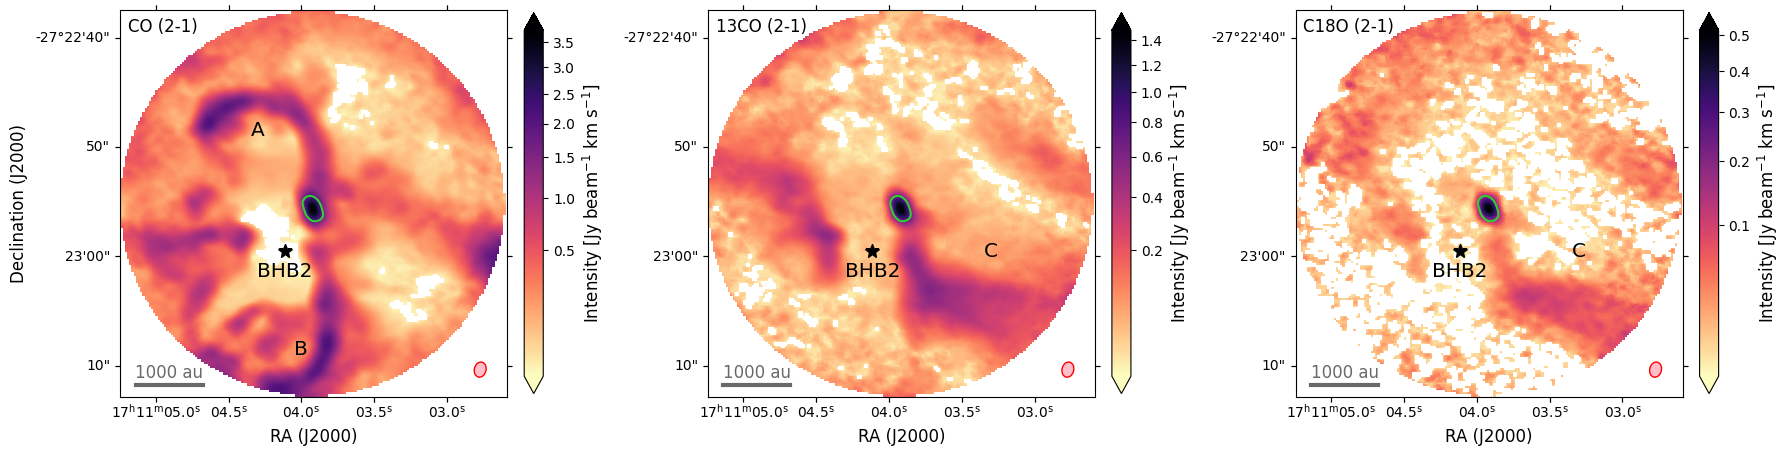

In [8]:
# Initialize the 1x3 figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': None}, sharex=True, sharey=True)

# Remove automatic subplots if you have fewer than 3 molecules
n_mols = len(scubes)
if n_mols < 3:
    for idx in range(n_mols, 3):
        fig.delaxes(axes[idx])

for i, (mol_line, scubevn_cm) in enumerate(scubes.items()):
    # Computing Moment 0
    moment0 = scubevn_cm.moment(order=0)
    ax_len = moment0.shape[0]

    # Set WCS projection for this subplot
    axes[i].remove()  # Remove blank axes
    ax = fig.add_subplot(1, 3, i + 1, projection=moment0.wcs)
    axes[i] = ax

    norm = PowerNorm(0.5)
    cmap = plt.cm.magma_r
    im = ax.imshow(moment0.value, norm=norm, cmap=cmap, transform=ax.get_transform(moment0.wcs))

    # Show continuum contours
    if continuum:
        con = ax.contour(cont_dat,levels = np.array([5])*np.nanstd(cont_dat),colors = 'limegreen',linewidths = 1.5,#,linestyles='--',
                transform = ax.get_transform(WCS(hdu_cont).celestial))

    ## show BHB2
    bhb2_c = 'black'
    bhb2_coords = SkyCoord("17 11 04.1139442152 -27 22 59.489143068", unit=(u.hourangle, u.deg), frame='icrs')
    bhb2_ra = bhb2_coords.ra.deg
    bhb2_dec = bhb2_coords.dec.deg
    bhb2_x,bhb2_y = scubevn_cm.wcs.celestial.world_to_pixel_values(bhb2_ra,bhb2_dec)
    ax.plot(bhb2_x,bhb2_y,'*',color=bhb2_c,markersize=10)
    ax.text(bhb2_x,bhb2_y-12,"BHB2",color=bhb2_c, size='x-large', horizontalalignment='center')#,fontweight ='bold')

    ## labelling structures
    if mol_line == '12co':
        ax.text(struc_coords_pix['A'][0],struc_coords_pix['A'][1],"A",color=bhb2_c, size='x-large', horizontalalignment='center')#,fontweight ='bold')
        ax.text(struc_coords_pix['B'][0],struc_coords_pix['B'][1],"B",color=bhb2_c, size='x-large', horizontalalignment='center')#,fontweight ='bold')
    if (mol_line == 'c18o') or (mol_line == '13co'):
         ax.text(struc_coords_pix['C'][0],struc_coords_pix['C'][1],"C",color=bhb2_c, size='x-large', horizontalalignment='center')#,fontweight ='bold')
       
    
    # Add shorter colorbar for each subplot
    cb = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, extend='both', fraction=0.045, pad=0.04)
    cb.set_label(r"Intensity [Jy beam$^{-1}$ km s$^{-1}$]", size='large')

    ax.set_xlabel('RA (J2000)', size='large')
    if i == 0:
        ax.set_ylabel('Declination (J2000)', size='large')
    else:
        # ax.set_xlabel(' ', size='large')
        ax.set_ylabel(' ', size='large')
        # ax.coords[1].set_ticklabel_visible(False)  # latitude
        
    zx = 0
    zy = zx

    # Show length-scale
    l = 1000 * u.au
    l_deg = (l / (src_dist.to(u.au)) * u.radian).to(u.degree).value
    l_pix = l_deg / hdu.header['CDELT2']
    ax.plot([zx + 0.04 * ax_len, zx + 0.04 * ax_len + l_pix], [zy + 0.03 * ax_len, zy + 0.03 * ax_len],
            color='dimgrey', linewidth=3)
    ax.text(zx + 0.04 * ax_len + l_pix / 2, zy + 0.05 * ax_len, "1000 au",
            color='dimgrey', size='large', horizontalalignment='center')

    # Show beam-size
    ell = patches.Ellipse((0.93 * ax_len, 0.07 * ax_len),
                          bmaj / hdu.header['CDELT2'] / 60 / 60,  # arcsec to degree to pixels
                          bmin / hdu.header['CDELT2'] / 60 / 60,
                          angle=bpa,
                          facecolor='pink', edgecolor='red')
    ax.add_patch(ell)

    ## Add line name
    # ax.set_title(mol_line_labels[mol_line], size='large')
    ax.text(0.02*ax_len,0.98*ax_len,mol_line_labels[mol_line], size='large',verticalalignment = 'top')
    
    # Axes limits
    ax.set_xlim(zx, moment0.shape[0] - zx)
    ax.set_ylim(zy, moment0.shape[1] - zy)

# fig.suptitle("Integrated Intensity Maps", fontsize='xx-large', y=0.90)  # bring supertitle a bit down

# Adjust layout
# fig.set_layout_engine('tight', pad=0, h_pad=0, w_pad=0)
plt.tight_layout(rect=[0, 0.03, 1, 0.97], w_pad=-0.5)  # leave less space for supertitle

if save_fig:
    plt.savefig(fig_path + 'moment0maps_C1_ACA.png', dpi=300, bbox_inches='tight')
plt.show()

/Users/agupta/opt/anaconda3/lib/python3.9/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/Users/agupta/opt/anaconda3/lib/python3.9/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /
/Users/agupta/opt/anaconda3/lib/python3.9/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


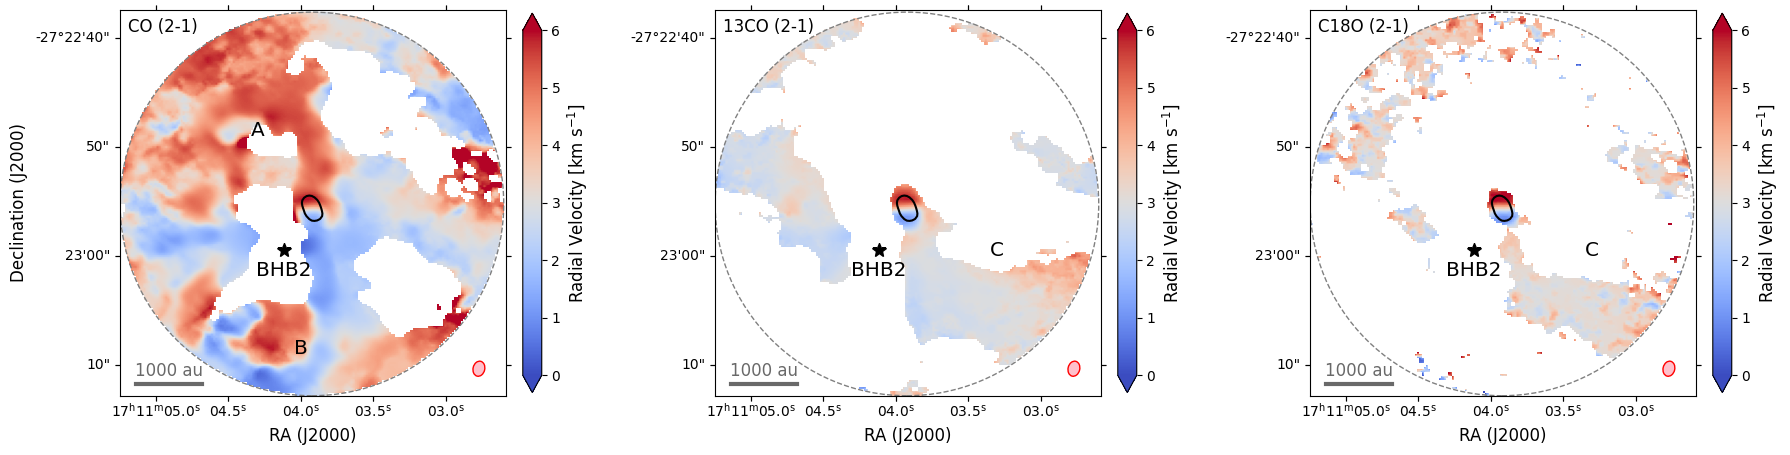

In [9]:
# Initialize the 1x3 figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': None}, sharex=True, sharey=True)

# Remove automatic subplots if you have fewer than 3 molecules
n_mols = len(scubes)
if n_mols < 3:
    for idx in range(n_mols, 3):
        fig.delaxes(axes[idx])

for i, (mol_line, scubevn_cm) in enumerate(scubes.items()):
    # Computing Moment 0
    moment0 = scubevn_cm.moment(order=0)
    mad_val  = mad(moment0.value,axis = None,nan_policy = 'omit')
    dV = abs(scubevn_cm.hdu.header['CDELT3'])*(u.km/u.s)
    Nspec = scubevn_cm.shape[0]
    em0 = (Nspec**(1/2))*dV*scubes_rms[mol_line]
    
    # Compution moment 1
    thresh_level = 9
    if mol_line == 'c18o': # Lower noise threshold for C18O emission because it is fainter
        thresh_level = 3
    thresh = thresh_level*em0
    scubevnm = scubevn_cm.with_mask(moment0 > thresh)
    moment1 = scubevnm.moment(order=1)

    # Set WCS projection for this subplot
    axes[i].remove()  # Remove blank axes
    ax = fig.add_subplot(1, 3, i + 1, projection=moment1.wcs)
    axes[i] = ax

    vmin_cmap = 0
    vmax_cmap=6
    norm=PowerNorm(1, vmin=vmin_cmap, vmax=vmax_cmap)
    # cmap = plt.cm.jet
    # cmap = plt.cm.RdYlBu_r
    cmap = plt.cm.coolwarm
    # cmap = plt.cm.berlin
    im = ax.imshow(moment1.value, norm=norm, cmap=cmap, transform=ax.get_transform(moment1.wcs))

    # Show continuum contours
    if continuum:
        con = ax.contour(cont_dat,levels = np.array([5])*np.nanstd(cont_dat),colors = 'black',linewidths = 1.5,#linestyles='--',
                transform = ax.get_transform(WCS(hdu_cont).celestial))

    ## show BHB2
    bhb2_c = 'black'
    bhb2_coords = SkyCoord("17 11 04.1139442152 -27 22 59.489143068", unit=(u.hourangle, u.deg), frame='icrs')
    bhb2_ra = bhb2_coords.ra.deg
    bhb2_dec = bhb2_coords.dec.deg
    bhb2_x,bhb2_y = scubevn_cm.wcs.celestial.world_to_pixel_values(bhb2_ra,bhb2_dec)
    ax.plot(bhb2_x,bhb2_y,'*',color=bhb2_c,markersize=10)
    ax.text(bhb2_x,bhb2_y-12,"BHB2",color=bhb2_c, size='x-large', horizontalalignment='center')#,fontweight ='bold')

    ## labelling structures
    if mol_line == '12co':
        ax.text(struc_coords_pix['A'][0],struc_coords_pix['A'][1],"A",color=bhb2_c, size='x-large', horizontalalignment='center')#,fontweight ='bold')
        ax.text(struc_coords_pix['B'][0],struc_coords_pix['B'][1],"B",color=bhb2_c, size='x-large', horizontalalignment='center')#,fontweight ='bold')
    if (mol_line == 'c18o') or (mol_line == '13co'):
         ax.text(struc_coords_pix['C'][0],struc_coords_pix['C'][1],"C",color=bhb2_c, size='x-large', horizontalalignment='center')#,fontweight ='bold')

    # Add shorter colorbar for each subplot
    cb = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, extend='both', fraction=0.045, pad=0.04)
    cb.set_label(r"Radial Velocity [km s$^{-1}$]", size='large')

    ax.set_xlabel('RA (J2000)', size='large')
    if i == 0:
        ax.set_ylabel('Declination (J2000)', size='large')
    else:
        # ax.set_xlabel(' ', size='large')
        ax.set_ylabel(' ', size='large')
        # ax.coords[1].set_ticklabel_visible(False)  # latitude

    zx = 0
    zy = zx

    # Show length-scale
    l = 1000 * u.au
    l_deg = (l / (src_dist.to(u.au)) * u.radian).to(u.degree).value
    l_pix = l_deg / hdu.header['CDELT2']
    ax.plot([zx + 0.04 * ax_len, zx + 0.04 * ax_len + l_pix], [zy + 0.03 * ax_len, zy + 0.03 * ax_len],
            color='dimgrey', linewidth=3)
    ax.text(zx + 0.04 * ax_len + l_pix / 2, zy + 0.05 * ax_len, "1000 au",
            color='dimgrey', size='large', horizontalalignment='center')

    # Show beam-size
    ell = patches.Ellipse((0.93 * ax_len, 0.07 * ax_len),
                          bmaj / hdu.header['CDELT2'] / 60 / 60,  # arcsec to degree to pixels
                          bmin / hdu.header['CDELT2'] / 60 / 60,
                          angle=bpa,
                          facecolor='pink', edgecolor='red')
    ax.add_patch(ell)

    ## Add circle showing angular scale
    # ang_scale_pix = ax_len/2#-25
    ang_scale_pix = ang_scale.value/moment1.header['CDELT2']/60/60 -0.5
    big_cir = patches.Circle((ang_scale_pix,ang_scale_pix),ang_scale_pix,facecolor = "None",edgecolor='grey',linestyle='--')
    ax.add_patch(big_cir)

    ## Add line name
    ax.text(0.02*ax_len,0.98*ax_len,mol_line_labels[mol_line], size='large',verticalalignment = 'top')
    
    # Axes limits
    ax.set_xlim(zx, moment0.shape[0] - zx)
    ax.set_ylim(zy, moment0.shape[1] - zy)

# fig.suptitle("Intensity Weighted Velocity Maps", fontsize='xx-large', y=0.90)  # bring supertitle a bit down

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # leave less space for supertitle

if save_fig:
    plt.savefig(fig_path + 'moment1maps_C1_ACA.png', dpi=300, bbox_inches='tight')
plt.show()

## Channel maps

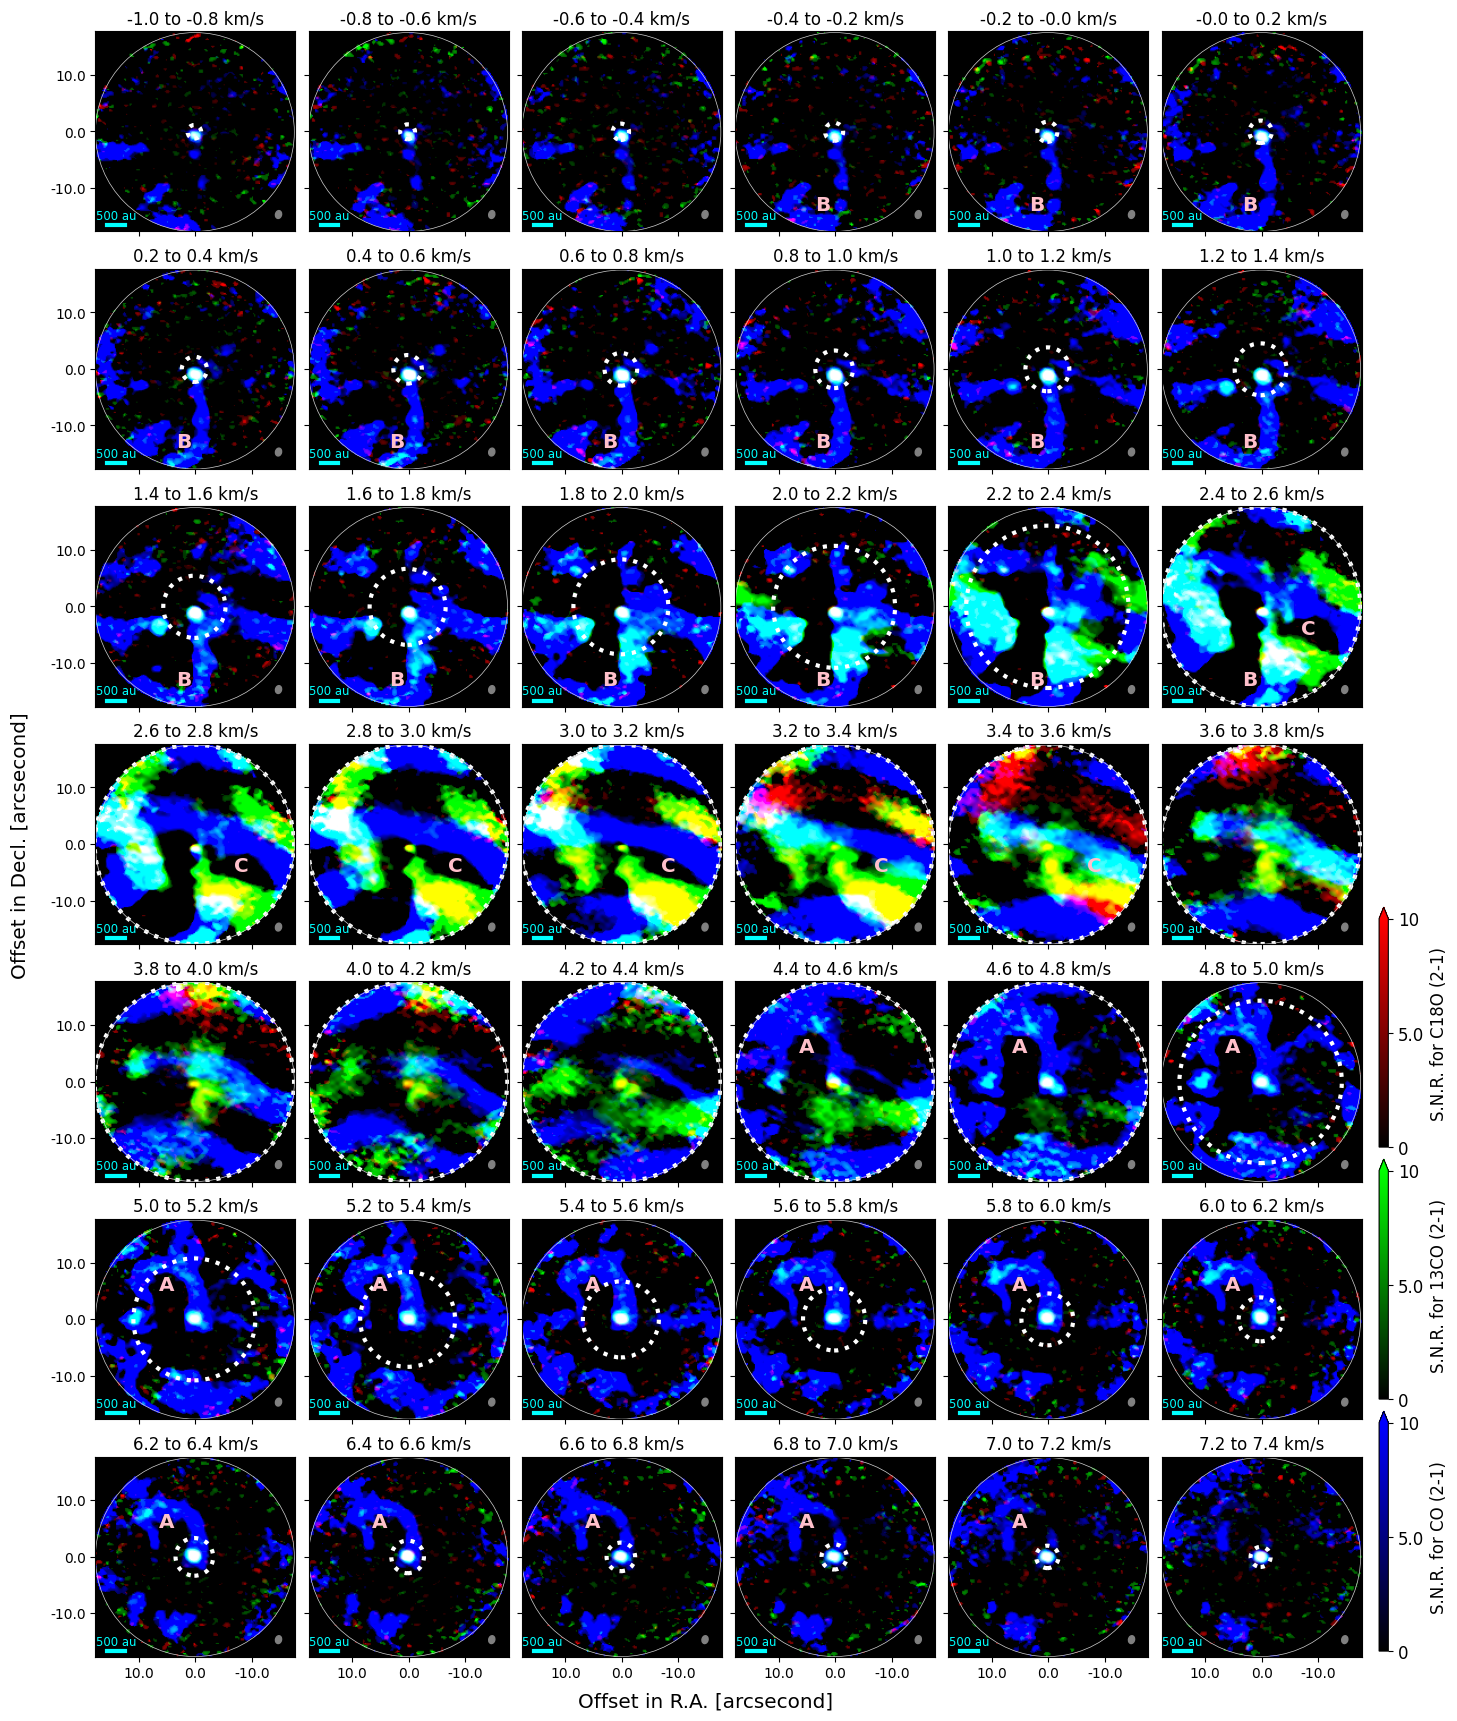

In [10]:
                
## Setting channel velocities
dv = 0.2  # rough range of velocities in each panel of channel map
vmin_cm = -1*u.km/u.s
vmax_cm = 7.5*u.km/u.s
vel_range = np.arange(vmin_cm.value,vmax_cm.value+0.5*dv,dv) # velocity boundaries for each panel
nplts = len(vel_range)-1 # no. of panels in channel maps

## Dictionaries for plotting stuff 
colours = ['blue','green','red']
mol_line_colours = {list(scubes.keys())[i]: colours[i] for i in range(3)} # Colors for each line

## Setting layout
cno = 6  # no. of cols
rno = int(np.ceil(nplts/cno))  # no. of rows, dependent on cno
fig = plt.figure(figsize=((2.5-0.3)*(cno),(2.5-0.1)*(rno)), layout = 'constrained') # Creating big figure
# fig.get_layout_engine().set(wspace=-2,hspace=0)

## Creating channel maps
axs = fig.subplots(rno,cno, sharey=True, sharex=True) # aces for each panels

## Setting seperations and stuff
norm=PowerNorm(1)
dt = 10  # Tick seperation in arcsec
tick_lab = np.linspace(-dt,dt,3).round(0)  # labels on ticks in delta arcsec
len_x = np.abs(scubevn_cm.shape[2]) # no. of pixels in x directions, NOTE the index may not always be 2
len_y = np.abs(scubevn_cm.shape[1]) # no. of pixels in y directions, NOTE the index may not always be 1
delta_x = hdu.header['CDELT1'] # Conversion factor from angle to pixel
delta_y = hdu.header['CDELT2'] # Conversion factor from angle to pixel
# tick_loc = tick_lab/60/60/delta + (len_x+len_y)/2/2  # arcsec offset to pixel offset for location
x_tick_loc = tick_lab/60/60/delta_x + len_x/2  # arcsec offset to pixel offset for location
y_tick_loc = tick_lab/60/60/delta_y + len_y/2  # arcsec offset to pixel offset for location
sat_thresh = 10 # Saturation threshold for SNR values

for io in range(nplts):
    ax = axs.flat[io] # panel to work on

    ## Getting and displaying values for each panel
    panels = {}
    for mol_line,scubevn_cm in list(scubes.items())[::-1]:
        scube_channel = scubevn_cm.spectral_slab(vel_range[io]*u.km/u.s, vel_range[io+1]*u.km/u.s)  
        tm0 = scube_channel.moment(order=0)
        dV_tm0 = abs(scube_channel.hdu.header['CDELT3'])*(u.km/u.s)
        Nspec_tm0 = scube_channel.shape[0]
        etm0 = (Nspec_tm0**(1/2))*dV_tm0*scubes_rms[mol_line]
        # spectra_i[mol_line].append((np.nansum(tm0)/(Nspec_tm0*dV_tm0)).value) # storing values for spectra
        # print(mol_line,np.nansum(tm0),np.nansum(etm0),Nspec_tm0,vel_range[io],vel_range[io+1])
        tm0_norm=tm0/etm0/sat_thresh
        tm0_norm[tm0_norm<0] = 0
        tm0_norm[tm0_norm>1] = 1
        tm0_norm[np.isnan(tm0_norm)] = 0
        panels[mol_line] = tm0_norm.value
    panels_restruct = np.dstack(list(panels.values())) #np.array(list(panels.values()))
    im = ax.imshow(panels_restruct,norm=norm)#, alpha=0.9)
    
    ## More layout
    ax.invert_yaxis() 
    zx = 0   # Can be used to zoom in 
    zy = zx
    ax.set_xlim(zx,len_x-zx)
    ax.set_ylim(zy,len_y-zy)

    ## Show beam-size
    ell = patches.Ellipse((len_x-zx-15,zy+15)
                           ,bmaj/hdu.header['CDELT2']/60/60   #arcsec to degree to pixels
                           ,bmin/hdu.header['CDELT2']/60/60
                           ,angle = bpa
                           ,color = 'grey')
    ax.add_patch(ell)

    ## Show length-scale
    l = 500*u.au
    l_deg = (l/(src_dist.to(u.au)) *u.radian).to(u.degree).value
    l_pix = l_deg/hdu.header['CDELT2']
    ax.plot([zx+0.06*len_x,zx+0.06*len_y+l_pix],[zy+0.03*len_x,zy+0.03*len_y],
            color = 'cyan', linewidth = 3)
    ax.text(zx+0.06*len_x+l_pix/2,zy+0.06*len_y,"500 au"
            ,color = 'cyan', size = 'small', horizontalalignment = 'center')

    ## Show bound circle
    v_c = (vel_range[io]+vel_range[io+1])/2*(u.km/u.s) # Channel velocity
    dv_disk_channel = np.abs(v_c-src_v)
    src_x,src_y = scubevn_cm.wcs.celestial.world_to_pixel_values(src_ra,src_dec)
    
    r = ((2*const.G*src_M)/(dv_disk_channel**2))
    r_deg = (r/(src_dist.to(u.au)) *u.radian).to(u.degree).value
    r_pix = r_deg/delta
    if r_pix>max(src_x,src_y):  # limit the largest possible circle to not leave the map
        r_pix = max(src_x,src_y)        
    circ = patches.Circle((src_x,src_y)
                           ,r_pix   #radius in pixels
                           ,facecolor = 'None',edgecolor = 'white'
                           ,linestyle = ':',linewidth = 3)
    ax.add_patch(circ)

    ## show BHB2
    # bhb2_c = 'white'
    # bhb2_coords = SkyCoord("17 11 04.1139442152 -27 22 59.489143068", unit=(u.hourangle, u.deg), frame='icrs')
    # bhb2_ra = bhb2_coords.ra.deg
    # bhb2_dec = bhb2_coords.dec.deg
    # bhb2_x,bhb2_y = tm0.wcs.celestial.world_to_pixel_values(bhb2_ra,bhb2_dec)
    # ax.plot(bhb2_x,bhb2_y,'*',color=bhb2_c,markersize=5)
    # ax.text(bhb2_x,bhb2_y-12,"BHB2",color=bhb2_c, size='medium', horizontalalignment='center')

    ## labelling structures
    struc_coords_pix_cm = {}
    for struc,coords in struc_coords.items():
        struc_coords_pix_cm[struc]= tm0.wcs.celestial.world_to_pixel_values(coords.ra,coords.dec)
    bhb2_c = 'pink'
    label_size = 'x-large'
    if (vel_range[io]>4.3) and (vel_range[io]<7):
        ax.text(struc_coords_pix_cm['A'][0],struc_coords_pix_cm['A'][1]-5,"A",color=bhb2_c, size=label_size, horizontalalignment='center',fontweight ='bold')
    if (vel_range[io]>-0.6) and (vel_range[io]<2.4):
        ax.text(struc_coords_pix_cm['B'][0]-5,struc_coords_pix_cm['B'][1],"B",color=bhb2_c, size=label_size, horizontalalignment='center',fontweight ='bold')
    if (vel_range[io]>2.2) and (vel_range[io]<3.5):
        ax.text(struc_coords_pix_cm['C'][0],struc_coords_pix_cm['C'][1],"C",color=bhb2_c, size=label_size, horizontalalignment='center',fontweight ='bold')

    # ## Show bound circle corrected for projection effects    
    # r = ((2/3)**1.5*const.G*src_M)/(dv_disk_channel**2)
    # r_deg = (r/(src_dist.to(u.au)) *u.radian).to(u.degree).value
    # r_pix = r_deg/delta
    # if r_pix>max(src_x,src_y):  # limit the largest possible circle to not leave the map
    #     r_pix = max(src_x,src_y)        
    # circ = patches.Circle((src_x,src_y)
    #                        ,r_pix   #radius in pixels
    #                        ,facecolor = 'None',edgecolor = 'magenta'
    #                        ,linestyle = ':',linewidth = 2)
    # ax.add_patch(circ)
    
    ## show circular field of view
    circ2 = patches.Circle((len_x//2,len_y//2)
                           ,(len_x-zx)//2   #radius in pixels
                           ,facecolor = 'None',edgecolor = 'lightgrey'
                           ,linestyle = '-',linewidth = 0.5)
    ax.add_patch(circ2)

    ## more layout stuff
    ax.set_title(str(np.round(vel_range[io],2))+' to '+str(np.round(vel_range[io+1],2))+' km/s'
                ,size = 'large')
    ax.set_xticks(x_tick_loc)
    ax.set_xticklabels(tick_lab)
    ax.set_yticks(y_tick_loc)
    ax.set_yticklabels(tick_lab)

## Hide individual axes
for i in range(nplts,rno*cno):
    axs.flat[i].axis('off')

# fig.suptitle(obj_name+" (Mstar: {:.2f})".format(src_M),fontsize='xx-large') # title, works with constrained layout..
fig.text(0.5, -0.01, 'Offset in R.A. [arcsecond]', ha='center', va='center',size = 'x-large') # x label
fig.text(-0.02, 0.5, 'Offset in Decl. [arcsecond]', ha='center', va='center', rotation='vertical',size = 'x-large') # y label
# fig.set_constrained_layout_pads(w_pad=0,wspace = -0.3,hspace = -0.1, h_pad=0.2)

## Creating RBG colourbars
cbar_wspace = 0.05
for i in range(len(scubes)):
    mol_line = list(scubes.keys())[i] 
    # cbar_ax = fig.add_axes([1.01 + i*cbar_wspace, 0.3, 0.007, 0.6]) # [left, bottom, width, height] of the new axes
    # cbar_ax = fig.add_axes([1.01 + i*cbar_wspace, 0.3, 0.007, 1/rno]) # [left, bottom, width, height] of the new axes
    # cbar_ax = fig.add_axes([1.01, 0.4 - i*0.15, 0.007, 1/rno]) # [left, bottom, width, height]
    cbar_ax = fig.add_axes([1.01, 0.02 + i*0.15, 0.007, 1/rno]) # [left, bottom, width, height]
    cmap_name = 'S.N.R. for '+ mol_line_labels[mol_line]

    color_grad = [[0, 0, 0], [0, 0, 0]]
    color_grad[1][2-i] = 1 # Set actual colour gradient (black to R/G/B)
    cmap = LinearSegmentedColormap.from_list(cmap_name, color_grad)#, N=n_bin) # Creating colormap
    
    cb = fig.colorbar(ScalarMappable(norm = None, cmap = cmap), cax=cbar_ax, label = cmap_name, extend = 'max') # adding colormap
    cb.set_ticks([0, 0.5, 1])  # setting tick locations
    cb.set_ticklabels(['0', str(sat_thresh/2), str(sat_thresh)])  # setting tick values
    cb.ax.yaxis.label.set_size(10)  # Set the font size after creation
    cb.ax.yaxis.label.set_size('large')  # Set the colorbar label font size
    cb.ax.tick_params(labelsize='large')  # Set the tick labels font size

if save_fig:
    fig.savefig(fig_path+"CombinedCOchannelmaps.png", bbox_inches='tight', pad_inches=0.3,dpi = 150)
plt.show()